#### Import libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import mnist, fashion_mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings("ignore")

#### Download data

In [ ]:
(X, y), (X_test, y_test) = fashion_mnist.load_data()

# Reshaping the data matrices
X = X.reshape(X.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)

# Normalizing the pixel intensities
X = X/255.0
X_test = X_test/255.0

# Split the X_train into a training set and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
# Number of training examples
M = X_train.shape[0]

# Number of validation samples
Mval = X_val.shape[0]

# Number of test examples
Mtest = X_test.shape[0]

# Number of features in the dataset
num_features = 784

# Number of classes
num_classes = len(np.unique(y_train))

# One hot encoding for class labels
y_train_one_hot = np.zeros((10, M))
y_train_one_hot[y_train, np.array(list(range(M)))] = 1
# y_train_one_hot = y_train_one_hot.T

y_val_one_hot = np.zeros((10, Mval))
y_val_one_hot[y_val, np.array(list(range(Mval)))] = 1
# y_val_one_hot = y_val_one_hot.T

y_test_one_hot = np.zeros((10, Mtest))
y_test_one_hot[y_test, np.array(list(range(Mtest)))] = 1
# y_test_one_hot = y_test_one_hot.T

print("Number of images in the training set =", M)
print("Number of images in the validation set =", Mval)
print("Number of images in the test set =", Mtest)
print("Number of classes =", num_classes)
print("Number of features per example =", num_features)

Number of images in the training set = 54000
Number of images in the validation set = 6000
Number of images in the test set = 10000
Number of classes = 10
Number of features per example = 784


In [ ]:
# Modify shapes of the data matrices
X_train = X_train.T
X_val = X_val.T
X_test = X_test.T

#### Number of neurons in the input and output layers

In [ ]:
input_nodes = num_features
output_nodes = num_classes

#### Activation functions and their derivatives

In [ ]:
def sigmoid(x):
    return 1. / (1.+np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1-sigmoid(x))

def Relu(x):
    return np.maximum(0,x)

def Relu_derivative(x):
    return 1*(x>0) 

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return (1 - (np.tanh(x)**2))

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

#cross-entropy for our cost function
def compute_multiclass_loss(Y, Y_hat, batch_size, lamb, parameters):
    L = (-1.0 * np.sum(np.multiply(Y, np.log(Y_hat))))/batch_size

    acc = 0
    for i in range(1, len(parameters)//2 + 1):
        acc += np.sum(parameters["W"+str(i)]**2)

    L = L + (lamb/(2*batch_size))*acc

    return L

#### Initialize parameters

In [ ]:
def initialize_parameters(layer_dims, init_mode="xavier"):
    np.random.seed(42)
    params = {}
    previous_updates = {}
    for i in range(1, len(layer_dims)):
        if init_mode == 'random_normal':
            params["W"+str(i)] = np.random.randn(layer_dims[i], layer_dims[i-1]) * 0.01
        elif init_mode == 'random_uniform':
            params["W"+str(i)] = np.random.rand(layer_dims[i], layer_dims[i-1]) * 0.01
        elif init_mode == 'xavier':
            params["W"+str(i)]= np.random.randn(layer_dims[i],layer_dims[i-1])*np.sqrt(2/(layer_dims[i]+layer_dims[i-1]))
            
        params["b"+str(i)] = np.zeros((layer_dims[i], 1))
        
        previous_updates["W"+str(i)] = np.zeros((layer_dims[i], layer_dims[i-1]))
        previous_updates["b"+str(i)] = np.zeros((layer_dims[i], 1))

    return params,previous_updates

#### Forward Propagation

In [ ]:
def forward_propagate(X, params, activation_f):
    L = len(params)//2 + 1
    A = [None]*L # activations
    Z = [None]*L # pre-activations
    
    A[0] = X
    
    for l in range(1, L):
        W = params["W"+str(l)]
        b = params["b"+str(l)]
        
        Z[l] = np.matmul(W,A[l-1]) + b
        
        if l == L-1:
            A[l] = softmax(Z[l]) # activation function for output layer
        else:
            if activation_f == 'sigmoid':
                A[l] = sigmoid(Z[l])
            elif activation_f == 'relu':
                A[l] = Relu(Z[l])
            elif activation_f == 'tanh':
                A[l] = tanh(Z[l])
                
    output = A[L-1]

    return output,A,Z

#### Backpropagation

In [ ]:
def backprop(y_hat, y,A, Z, params, activation_f, batch_size, lamb):
    L = len(params)//2
    gradients = {}
    
    gradients["dZ"+str(L)] = A[L]-y
    
    for l in range(L,0,-1):
        gradients["dW" + str(l)] = (np.dot(gradients["dZ" + str(l)], A[l-1].T) + lamb*params["W"+str(l)]) / batch_size
        gradients["db" + str(l)] = np.sum(gradients["dZ" + str(l)], axis=1, keepdims=True) / batch_size
        
        if l>1:
            if activation_f == 'sigmoid':
                gradients["dZ"+str(l-1)] = np.matmul(params["W" + str(l)].T, gradients["dZ" + str(l)]) * sigmoid_derivative(Z[l-1])
            elif activation_f == 'relu':
                gradients["dZ"+str(l-1)] = np.matmul(params["W" + str(l)].T, gradients["dZ" + str(l)]) * Relu_derivative(Z[l-1])
            elif activation_f == 'tanh':
                gradients["dZ"+str(l-1)] = np.matmul(params["W" + str(l)].T, gradients["dZ" + str(l)]) * tanh_derivative(Z[l-1])
        
    return gradients

#### Optimizers

This block contains functions that implement stochastic gradient descent, momentum, RMSprop, Adam. Nadam and Nestorov accelerated gradient are implemented inside the NN_fit function.

In [ ]:
def update_params_sgd(parameters,grads,learning_rate):
    L = len(parameters) // 2 
    
    for l in range(1, L + 1):
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads["db" + str(l)]

    return parameters

def update_parameters_momentum(parameters, grads, learning_rate, beta, previous_updates):
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(1, L + 1):
        previous_updates["W"+str(l)] = beta*previous_updates["W"+str(l)] + (1-beta)*grads["dW" + str(l)]
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate*previous_updates["W"+str(l)]
        
        previous_updates["b"+str(l)] = beta*previous_updates["b"+str(l)] + (1-beta)*grads["db" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate*previous_updates["b"+str(l)]

    return parameters, previous_updates
    
def update_parameters_RMSprop(parameters, grads, learning_rate, beta, v):

    L = len(parameters) // 2 # number of layers in the neural network
    delta = 1e-6 # for numerical stability

    for l in range(1, L + 1):
        vdw = beta*v["W" + str(l)] + (1-beta)*np.multiply(grads["dW" + str(l)],grads["dW" + str(l)])
        vdb = beta*v["b" + str(l)] + (1-beta)*np.multiply(grads["db" + str(l)],grads["db" + str(l)])

        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)] / (np.sqrt(vdw)+delta)
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads["db" + str(l)] / (np.sqrt(vdb)+delta)

        v["W" + str(l)] = vdw
        v["b" + str(l)] = vdb

    return parameters,v

def update_parameters_adam(parameters, grads, learning_rate, v, m, t):
    L = len(parameters) // 2 # number of layers in the neural network
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-8

    for l in range(1, L+1):
        mdw = beta1*m["W"+str(l)] + (1-beta1)*grads["dW"+str(l)]
        vdw = beta2*v["W"+str(l)] + (1-beta2)*np.square(grads["dW"+str(l)])
        mw_hat = mdw/(1.0 - beta1**t)
        vw_hat = vdw/(1.0 - beta2**t)

        parameters["W"+str(l)] = parameters["W"+str(l)] - (learning_rate * mw_hat)/np.sqrt(vw_hat + epsilon)

        mdb = beta1*m["b"+str(l)] + (1-beta1)*grads["db"+str(l)]
        vdb = beta2*v["b"+str(l)] + (1-beta2)*np.square(grads["db"+str(l)])
        mb_hat = mdb/(1.0 - beta1**t)
        vb_hat = vdb/(1.0 - beta2**t)

        parameters["b"+str(l)] = parameters["b"+str(l)] - (learning_rate * mb_hat)/np.sqrt(vb_hat + epsilon)

        v["dW"+str(l)] = vdw
        m["dW"+str(l)] = mdw
        v["db"+str(l)] = vdb
        m["db"+str(l)] = mdb

    t = t + 1 # timestep
    return parameters, v, m, t

In [ ]:
def plot_cost_curve(train_costs, val_costs):
    plt.plot(list(range(len(train_costs))), train_costs, 'r', label="Training loss")
    plt.plot(list(range(len(val_costs))), val_costs, 'lime', label="Validation loss")
    plt.title("Training and Validation Loss vs Number of Epochs", size=16)
    plt.xlabel("Number of epochs", size=14)
    plt.ylabel("Loss", size=14)
    plt.grid()
    plt.legend()
    plt.show()

#### Function to fit the model

In [90]:
def NN_fit(X,y,X_val,y_val,layer_dims,learning_rate=0.01, activation_f='sigmoid', init_mode='xavier', optimizer = 'sgd', batch_size=512, epochs=10, beta=0.9, L2_lamb=0):

    params, previous_updates = initialize_parameters(layer_dims,init_mode)
    
    epoch_cost = []
    validation_epoch_cost = []

    params_look_ahead = params.copy() # initialization for nestorov
    
    count = 1

    t = 1 # initialize timestep for Adam optimizer
    v = previous_updates.copy()
    m = previous_updates.copy()

    while count<=epochs:
        count = count + 1 # increment the number of epochs
        for i in range(0, X.shape[1], batch_size):
            batch_count = batch_size
            if i + batch_size > X.shape[1]: # the last mini-batch might contain fewer than "batch_size" examples
                batch_count = X.shape[1] - i + 1

            if optimizer == 'nesterov':
                # print(beta)
                # print(L2_lambda)
                L = len(params)//2
                for l in range(1, L+1):
                    params_look_ahead["W"+str(l)] = params["W"+str(l)] - beta*previous_updates["W"+str(l)]
                    params_look_ahead["b"+str(l)] = params["b"+str(l)] - beta*previous_updates["b"+str(l)]
                    
                output,A,Z = forward_propagate(X[:,i:i+batch_size],params_look_ahead,activation_f)
                gradients = backprop(output,y[:,i:i+batch_size],A,Z,params_look_ahead,activation_f, batch_count, L2_lamb)
                params,previous_updates = update_parameters_momentum(params, gradients, learning_rate, beta, previous_updates)
                
            elif optimizer=='nadam':
                L = len(params)//2
                for l in range(1, L+1):
                    params_look_ahead["W"+str(l)] = params["W"+str(l)] - beta*previous_updates["W"+str(l)]
                    params_look_ahead["b"+str(l)] = params["b"+str(l)] - beta*previous_updates["b"+str(l)]

                output,A,Z = forward_propagate(X[:,i:i+batch_size],params_look_ahead,activation_f)
                gradients = backprop(output,y[:,i:i+batch_size],A,Z,params_look_ahead,activation_f, batch_count, L2_lamb)
                params, v, m, t = update_parameters_adam(params, gradients, learning_rate, v, m, t)

            else:
                output,A,Z = forward_propagate(X[:,i:i+batch_size],params,activation_f)
                gradients = backprop(output,y[:,i:i+batch_size],A,Z,params,activation_f, batch_count, L2_lamb)

                if optimizer == 'sgd':
                    params = update_params_sgd(params,gradients,learning_rate)
                elif optimizer == 'momentum':
                    params,previous_updates = update_parameters_momentum(params, gradients, learning_rate, beta, previous_updates)
                elif optimizer == 'RMSprop':
                    params,previous_updates = update_parameters_RMSprop(params, gradients, learning_rate, beta, previous_updates)
                elif optimizer == 'adam':
                    params, v, m, t = update_parameters_adam(params, gradients, learning_rate, v, m, t)

        # Mean loss for the full training set
        full_output, _, _ = forward_propagate(X, params, activation_f)
        cost = compute_multiclass_loss(y, full_output, M, L2_lamb, params)
        epoch_cost.append(cost)
        
        # Mean loss for the validation set
        out, _, _ = forward_propagate(X_val, params, activation_f)
        val_cost = compute_multiclass_loss(y_val, out, Mval, L2_lamb, params)
        validation_epoch_cost.append(val_cost)

        if (count % 2 == 0):
            print("Epoch number : {}".format(count))
            print("Training cost: ", cost, "\tValidation cost:",val_cost)

    print("\nFinal training cost:", cost)
    
    # Plot the training and validation cost curves
    plot_cost_curve(epoch_cost, validation_epoch_cost)
    
    return params, epoch_cost

In [91]:
def NN_predict(X_test, params, activation_f):
    output, _, _ = forward_propagate(X_test, params, activation_f)
    predictions = np.argmax(output, axis=0)
    return predictions

def NN_evaluate(X_train, y_train, X_test, y_test, params, activation_f):
    train_predictions= NN_predict(X_train, params, activation_f)
    test_predictions = NN_predict(X_test, params, activation_f)

    print("Training accuracy = {} %".format(round(accuracy_score(y_train, train_predictions) * 100), 3))
    print("Test accuracy = {} %".format(round(accuracy_score(y_test, test_predictions) * 100), 3))

    print("Classification report for the test set:\n")
    print(classification_report(y_test, test_predictions))

#### Setting Hyperparameters

In [102]:
layer_dims= [input_nodes,64,64,output_nodes]
LEARNING_RATE = 0.01
ACTIVATION = "tanh"
INITIALIZER = "xavier"
OPTIMIZER = "RMSprop"
BATCH_SIZE = 128
EPOCHS = 50
BETA = 0.9
L2_lambda = 0

#### Training the model

Epoch number : 2
Training cost:  0.554811912772375 	Validation cost: 0.5685468543550325
Epoch number : 4
Training cost:  0.44928731317597326 	Validation cost: 0.4753623521000989
Epoch number : 6
Training cost:  0.3893706276032009 	Validation cost: 0.42183629922896915
Epoch number : 8
Training cost:  0.39312354400399246 	Validation cost: 0.4244005888031302
Epoch number : 10
Training cost:  0.39308279343274904 	Validation cost: 0.42151684073373236
Epoch number : 12
Training cost:  0.3726196577674843 	Validation cost: 0.41900328619267696
Epoch number : 14
Training cost:  0.38769127635046147 	Validation cost: 0.427322826411094
Epoch number : 16
Training cost:  0.3891856831116318 	Validation cost: 0.42927959446305153
Epoch number : 18
Training cost:  0.3602069365508332 	Validation cost: 0.412280255239593
Epoch number : 20
Training cost:  0.38631557373003267 	Validation cost: 0.4255666529268706
Epoch number : 22
Training cost:  0.36311139512330565 	Validation cost: 0.4062032663797137
Epoch n

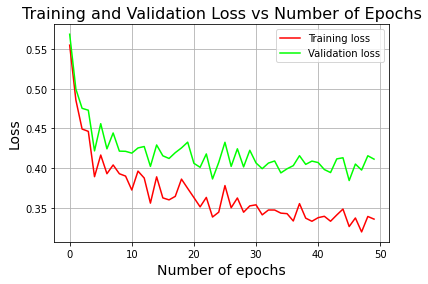

In [103]:
learned_parameters, epoch_cost = NN_fit(X_train, y_train_one_hot, X_val, y_val_one_hot, layer_dims,
                            learning_rate=LEARNING_RATE,
                            activation_f = ACTIVATION,
                            init_mode = INITIALIZER,
                            optimizer = OPTIMIZER,
                            batch_size = BATCH_SIZE,
                            epochs = EPOCHS,
                            beta = BETA,
                            L2_lamb = L2_lambda)

#### Model Evaluation

In [104]:
NN_evaluate(X_train, y_train, X_test, y_test, learned_parameters, ACTIVATION)

Training accuracy = 88 %
Test accuracy = 86 %
Classification report for the test set:

              precision    recall  f1-score   support

           0       0.83      0.78      0.80      1000
           1       0.98      0.95      0.97      1000
           2       0.73      0.77      0.75      1000
           3       0.85      0.88      0.87      1000
           4       0.72      0.81      0.76      1000
           5       0.97      0.92      0.94      1000
           6       0.66      0.59      0.62      1000
           7       0.91      0.96      0.93      1000
           8       0.97      0.96      0.97      1000
           9       0.94      0.94      0.94      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

